In [71]:
# setup.py

import sys
import pandas as pd
from pathlib import Path
import sqlite3

# Set project root and insert into sys.path
project_root = Path("/Users/buddy/Desktop/WGU-Reddit")
sys.path.insert(0, str(project_root))

# Import project modules
from utils.paths import DATA_DIR, OUTPUT_DIR, DB_PATH, CONFIG_PATH, path
from utils.db_connection import get_db_connection, load_posts_dataframe
from utils.cleaning_functions import cleaning_vader, cleaning_ngrams
from utils.sentiment import calculate_vader_sentiment, analyze_proximity_sentiment
from utils.filters import apply_filters
from IPython.display import display, HTML

# Load course list
course_list = pd.read_csv(DATA_DIR / "2025_06_course_list_with_college.csv")
output_dir = OUTPUT_DIR

# Add OpenAI module path to sys.path
OPENAI_MODULE_PATH = CONFIG_PATH.parent
if str(OPENAI_MODULE_PATH) not in sys.path:
    sys.path.insert(0, str(OPENAI_MODULE_PATH))


In [6]:

import pandas as pd
from utils.paths import DB_PATH


# Connect to DB and run filtered query
query = f"""
    SELECT post_id, title, selftext, permalink, created_utc
    FROM posts
"""

conn = sqlite3.connect(DB_PATH)
df = pd.read_sql_query(query, conn)
conn.close()

print(f"Loaded {len(df)} posts.")

Loaded 19001 posts.


In [7]:
from utils.filters import filter_by_date

# Filter to posts from 2025 only
df_filtered = filter_by_date(df, start_date="2025-01-01", end_date="2025-12-31")

from utils.filters import filter_by_course_codes

# Filter for posts matching exactly one course code using the default list
df_filtered = filter_by_course_codes(df_filtered, exact_match_count=1)
print(df_filtered.columns)

[filter_by_date] 10567 posts between 2025-01-01 and 2025-12-31
[filter_by_course_codes] 2616 posts matched 1 course codes
Index(['post_id', 'title', 'selftext', 'permalink', 'created_utc',
       'matched_course_codes'],
      dtype='object')


In [26]:
# Cell: Run VADER cleaning (no NLTK)

from utils.cleaning_functions import cleaning_vader

df_vader = cleaning_vader(df_filtered)
print(f"{len(df_vader)} rows.")
print(df_vader.columns)
display(df_vader[['post_id','text_clean', 'text_length']].head(5))

2616 rows.
Index(['post_id', 'title', 'selftext', 'permalink', 'created_utc',
       'matched_course_codes', 'text_clean', 'text_length'],
      dtype='object')


,post_id,text_clean,text_length
2,1k6iufu,ANYONE IN D277 I’m half way through Front End ...,228
7,1k6efwe,D196 PA vs OA I’ve been trying to find informa...,372
8,1k6eaph,C949 fail Pushed off taking this test for week...,145
9,1k6e9jx,C949 fail Pushed off taking this test for week...,144
12,1k6csnh,"MSSWE, DevOps Engineering - D777 Real Life App...",3535


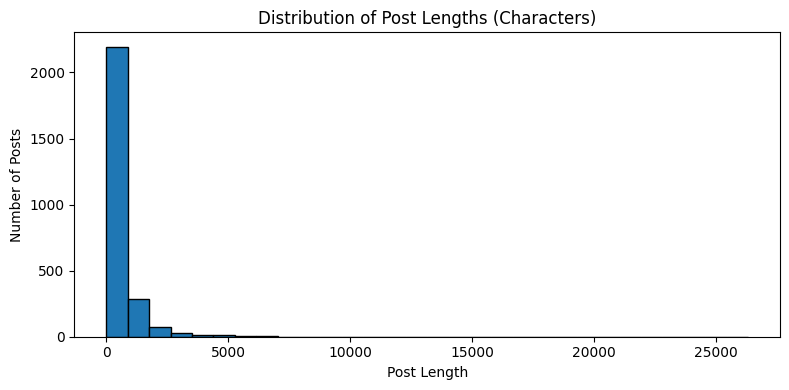


=== Histogram Bin Counts ===
   4–881 : 2194 posts
 881–1758: 288 posts
1758–2636: 74 posts
2636–3513: 29 posts
3513–4390: 14 posts
4390–5268: 10 posts
5268–6145: 2 posts
6145–7022: 2 posts
7022–7900: 1 posts
7900–8777: 1 posts
8777–9655: 0 posts
9655–10532: 0 posts
10532–11409: 0 posts
11409–12287: 0 posts
12287–13164: 0 posts
13164–14041: 0 posts
14041–14919: 0 posts
14919–15796: 0 posts
15796–16673: 0 posts
16673–17551: 0 posts
17551–18428: 0 posts
18428–19306: 0 posts
19306–20183: 0 posts
20183–21060: 0 posts
21060–21938: 0 posts
21938–22815: 0 posts
22815–23692: 0 posts
23692–24570: 0 posts
24570–25447: 0 posts
25447–26325: 1 posts


In [34]:
# filename: post_length_histogram_bin_counts.py

import matplotlib.pyplot as plt
import numpy as np

# Create histogram and capture bin counts
plt.figure(figsize=(8, 4))
counts, bins, _ = plt.hist(df_vader["text_length"], bins=30, edgecolor="black")
plt.title("Distribution of Post Lengths (Characters)")
plt.xlabel("Post Length")
plt.ylabel("Number of Posts")
plt.tight_layout()
plt.show()

# Print bin ranges and counts
bin_edges = bins.astype(int)
print("\n=== Histogram Bin Counts ===")
for i in range(len(bin_edges) - 1):
    print(f"{bin_edges[i]:>4}–{bin_edges[i+1]:<4}: {int(counts[i])} posts")

In [17]:
from collections import Counter

# Flatten and count course code mentions
all_codes = df_vader["matched_course_codes"].dropna().explode()
code_counts = Counter(all_codes)

# Convert to DataFrame and sort
course_freq_df = (
    pd.DataFrame(code_counts.items(), columns=["Course Code", "Frequency"])
    .sort_values(by="Frequency", ascending=False)
    .reset_index(drop=True)
)
output_path = OUTPUT_DIR / "2025_course_code_mentions.csv"
course_freq_df.to_csv(output_path, index=False)
print(f"Saved to: {output_path}")
display(course_freq_df.head(3))  # Show top 20

Saved to: /Users/buddy/Desktop/WGU-Reddit/outputs/2025_course_code_mentions.csv


,Course Code,Frequency
0,D196,90
1,D427,65
2,D101,64


In [68]:
# filter_top20_posts.py

from utils.filters import filter_by_course_codes

top_20_courses = course_freq_df["Course Code"].head(20).tolist()
df_top20 = filter_by_course_codes(df_vader, course_codes=top_20_courses, exact_match_count=1)

print(f"[Top 20 Filter] {len(df_top20)} posts, columns: {list(df_top20.columns)}")

[filter_by_course_codes] 930 posts matched 1 course codes
[Top 20 Filter] 930 posts, columns: ['post_id', 'title', 'selftext', 'permalink', 'created_utc', 'matched_course_codes', 'text_clean', 'text_length']


In [69]:
# add_sentiment_top20.py

from utils.sentiment import calculate_vader_sentiment

df_top20 = calculate_vader_sentiment(df_top20)
print(f"[Sentiment] Sentiment scores added. Columns now: {list(df_top20.columns)}")

[calculate_vader_sentiment] VADER sentiment scored for 930 posts.
[Sentiment] Sentiment scores added. Columns now: ['post_id', 'title', 'selftext', 'permalink', 'created_utc', 'matched_course_codes', 'text_clean', 'text_length', 'VADER_Compound']


In [72]:
# prepare_gui_posts.py

df_gui = (
    df_top20.rename(columns={"matched_course_codes": "course_code"})
    .assign(course_code=lambda df: df["course_code"].str[0])
    .loc[:, ["post_id", "title", "selftext", "permalink", "created_utc", "course_code", "text_length", "VADER_Compound"]]
)

output_path = output_dir / "gui_posts_top20.csv"
df_gui.to_csv(output_path, index=False)
print(f"[Saved] {len(df_gui)} posts → {output_path.name}")

[Saved] 930 posts → gui_posts_top20.csv


In [33]:
# filename: save_by_course_jsonl.py

import pandas as pd
from pathlib import Path

# Assumes df_top20 is your filtered DataFrame with 'matched_course_codes' and 'text_clean'
df = df_top20.copy()

# Ensure only one course per row
df = df.explode("matched_course_codes").dropna(subset=["matched_course_codes"])

# Rename column to 'text' for output
df = df.rename(columns={"text_clean": "text"})

# Set output path
output_dir = Path("/Users/buddy/Desktop/WGU-Reddit/outputs/by_course_2025")
output_dir.mkdir(parents=True, exist_ok=True)

# Iterate by course code and save as JSONL
for course, group in df.groupby("matched_course_codes"):
    out_path = output_dir / f"{course}_posts.jsonl"
    group[["post_id", "text"]].to_json(
        out_path, orient="records", lines=True, force_ascii=False
    )

print(f"Saved {df['matched_course_codes'].nunique()} course files to {output_dir}")

Saved 20 course files to /Users/buddy/Desktop/WGU-Reddit/outputs/by_course_2025


### LLM Classifier
1. configs
2. classifier
3. runner script

In [63]:
# separated config

from pathlib import Path
from datetime import datetime


BATCH_CHAR_LIMIT = 5000
MAX_POSTS_PER_BATCH = 10

INPUT_DIR = Path("/Users/buddy/Desktop/WGU-Reddit/outputs/by_course_2025")
OUTPUT_DIR = Path("/Users/buddy/Desktop/WGU-Reddit/outputs/classified_2025")
LOG_DIR = Path("/Users/buddy/Desktop/WGU-Reddit/outputs")
LOG_FILE = LOG_DIR / f"classify_log_{datetime.now():%Y-%m-%d}.log"

OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
LOG_DIR.mkdir(parents=True, exist_ok=True)

In [64]:
# filename: gpt_classifier.py

import json
import logging

def load_jsonl(path):
    with open(path, "r", encoding="utf-8") as f:
        return [json.loads(line) for line in f]

def save_jsonl(records, path):
    with open(path, "w", encoding="utf-8") as f:
        for r in records:
            f.write(json.dumps(r, ensure_ascii=False) + "\n")

def log_batch(posts, results, mode):
    ids = [p["post_id"] for p in posts]
    texts = [p["text"][:10] + "..." for p in posts]
    total_chars = sum(len(p["text"]) for p in posts)
    logging.info(
        f"[{mode.upper()}] post_ids={ids} | char_count={total_chars} | inputs={texts} | outputs={results}"
    )

def log_gpt_config():
    system_msg = "You are a classifier for Reddit posts about university courses."
    prompt_template = """\
Classify it using one or more of the following categories (by number):
0: Assessment & Exam Content — PA, OA, proctoring, retaking, etc  
1: Course Content Issues — outdated, incorrect, missing, or misleading course material  
2: Study Support & Resources — study materials, guides, notes, etc  
3: Course Planning & Timing — degree plan, course order, pacing guide, timeline  
4: Celebration & Motivation — passing, graduating, confetti, encouragement  
5: uncategorized — not fitting into other categories

INTENT TAGS (optional):
0: help_request — explicit asks for help, support, etc  
1: advice_offered — offering advice, tips, etc

Return the following JSON structure:

{
  "post_id": "<id>",
  "categories": [...],
  "intent_tags": [...]
}
"""
    logging.info("[GPT CONFIG] model=gpt-4o-mini")
    logging.info("[GPT CONFIG] system_message=%s", system_msg)
    logging.info("[GPT CONFIG] prompt_template=%s", prompt_template)

def classify_file(input_path):

    posts = load_jsonl(input_path)
    output_records = []
    batch = []
    char_count = 0

    for post in posts:
        text = post["text"]
        length = len(text)

        if length > 10000:
            log_batch([post], [], mode="flagged-too-long")
            continue

        if length > 5000:
            result = classify_reddit_post(post_id=post["post_id"], text=text)
            if hasattr(result, "model_dump"):
                result = result.model_dump()  # ✅ fix deprecated .dict()
            log_batch([post], [result], mode="solo")
            output_records.append(result)
            continue

        if len(batch) < MAX_POSTS_PER_BATCH and (char_count + length) <= BATCH_CHAR_LIMIT:
            batch.append(post)
            char_count += length
        else:
            results = []
            for p in batch:
                r = classify_reddit_post(p["post_id"], p["text"])
                if hasattr(r, "model_dump"):
                    r = r.model_dump()  # ✅ fix deprecated .dict()
                results.append(r)
            log_batch(batch, results, mode="batched")
            output_records.extend(results)
            batch = [post]
            char_count = length

    if batch:
        results = []
        for p in batch:
            r = classify_reddit_post(p["post_id"], p["text"])
            if hasattr(r, "model_dump"):
                r = r.model_dump()
            results.append(r)
        log_batch(batch, results, mode="batched")
        output_records.extend(results)

    out_name = input_path.stem.replace("_posts", "_classified") + ".jsonl"
    save_jsonl(output_records, OUTPUT_DIR / out_name)

In [65]:
log_gpt_config()  # Log LLM model and prompt details once

for path in INPUT_DIR.glob("*_posts.jsonl"):
    classify_file(path)
    print(f"✅ Finished: {path.name}")

/var/folders/4k/nn6_64p916g2s6wytgx_n4rr0000gn/T/ipykernel_2266/254867707.py:67: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  return response.choices[0].message.parsed.dict()


✅ Finished: D333_posts.jsonl
✅ Finished: D103_posts.jsonl
✅ Finished: D426_posts.jsonl
✅ Finished: D336_posts.jsonl
✅ Finished: D216_posts.jsonl
✅ Finished: D335_posts.jsonl
✅ Finished: D288_posts.jsonl
✅ Finished: D196_posts.jsonl
✅ Finished: D427_posts.jsonl
✅ Finished: D102_posts.jsonl
✅ Finished: D487_posts.jsonl
✅ Finished: D278_posts.jsonl


In [44]:
# filename: viewer_classified_posts.ipynb (cell)

import pandas as pd
import json
from pathlib import Path
import ipywidgets as widgets
from IPython.display import display, clear_output

# === Load classified file ===
input_path = Path("/Users/buddy/Desktop/WGU-Reddit/outputs/classified_2025/C207_classified.jsonl")

with open(input_path, "r", encoding="utf-8") as f:
    data = [json.loads(line) for line in f]

# You may need to merge with original text file to show post content
original_path = Path("/Users/buddy/Desktop/WGU-Reddit/outputs/by_course_2025") / input_path.name.replace("_classified", "_posts")
with open(original_path, "r", encoding="utf-8") as f:
    original_data = {p["post_id"]: p["text"] for p in (json.loads(line) for line in f)}

# Merge
for item in data:
    item["text"] = original_data.get(item["post_id"], "")

df = pd.DataFrame(data)

# === Widgets ===
category_options = [
    (f"{i} - {label}", i) for i, label in enumerate([
        "Assessment & Exam Content", "Course Content Issues", "Study Support & Resources",
        "Course Planning & Timing", "Celebration & Motivation", "Uncategorized"
    ])
]

intent_options = [
    ("help_request", 0),
    ("advice_offered", 1)
]

category_filter = widgets.SelectMultiple(
    options=category_options,
    value=[],
    description="Categories",
    layout=widgets.Layout(width="300px", height="160px")
)

intent_filter = widgets.SelectMultiple(
    options=intent_options,
    value=[],
    description="Intents",
    layout=widgets.Layout(width="300px", height="80px")
)

search_box = widgets.Text(
    placeholder='Search text...',
    description='Search:',
    layout=widgets.Layout(width='400px')
)

output_area = widgets.Output()

def filter_posts(*args):
    with output_area:
        clear_output()
        filtered = df.copy()
        
        # Filter categories
        if category_filter.value:
            filtered = filtered[filtered["categories"].apply(lambda x: any(c in x for c in category_filter.value))]
        
        # Filter intents
        if intent_filter.value:
            filtered = filtered[filtered["intent_tags"].apply(lambda x: any(i in x for i in intent_filter.value))]

        # Text search
        search_term = search_box.value.strip().lower()
        if search_term:
            filtered = filtered[filtered["text"].str.lower().str.contains(search_term)]

        # Display results
        if filtered.empty:
            print("No posts match your filters.")
        else:
            for _, row in filtered.iterrows():
                print(f"Post ID: {row['post_id']}")
                print(f"Categories: {row['categories']}")
                print(f"Intent Tags: {row['intent_tags']}")
                print(f"Text: {row['text'][:500]}")
                print("-" * 80)

# Hook up filters
category_filter.observe(filter_posts, names='value')
intent_filter.observe(filter_posts, names='value')
search_box.observe(filter_posts, names='value')

# Layout
filter_box = widgets.HBox([category_filter, intent_filter])
display(filter_box, search_box, output_area)

# Trigger initial display
filter_posts()

Text(value='', description='Search:', layout=Layout(width='400px'), placeholder='Search text...')

Output()

## Note: $0.04 was the cost for these

In [2]:
# filename: test_openai_config.py

import yaml
from openai import OpenAI
from utils.paths import CONFIG_PATH

# Load config
with open(CONFIG_PATH) as f:
    config = yaml.safe_load(f)

# Instantiate client
client = OpenAI(api_key=config["OPENAI_API_KEY"])

# Run simple GPT test
response = client.chat.completions.create(
    model="gpt-4o",
    messages=[
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": "Summarize what WGU is in one sentence."}
    ]
)

# Print response
print("=== GPT Response ===")
print(response.choices[0].message.content)

=== GPT Response ===
WGU, or Western Governors University, is a nonprofit, online university offering competency-based degree programs designed to provide flexible and affordable higher education for working adults.


In [4]:
# zero_shot_functions_cell

import yaml
from openai import OpenAI
from pydantic import BaseModel
from utils.paths import CONFIG_PATH

# Load OpenAI API key from config
with open(CONFIG_PATH) as f:
    config = yaml.safe_load(f)

# Instantiate client with key from config
client = OpenAI(api_key=config["OPENAI_API_KEY"])

# Define Pydantic response schema
class CategoryResponse(BaseModel):
    category: str
    confidence: float
    reasoning: str

def true_zero_shot_classify(text: str, show_prompt: bool = False):
    """TRUE zero-shot: No examples, no predefined categories."""
    
    prompt = f"""Classify this Reddit post into a natural topic category. 
Provide just a category name, confidence score, and brief reasoning.

Post: {text}"""

    if show_prompt:
        print("=== TRUE ZERO-SHOT PROMPT ===")
        print(prompt)
        print("=" * 30)

    try:
        completion = client.chat.completions.parse(
            model="gpt-4o-mini",
            messages=[
                {"role": "system", "content": "You classify text into natural categories."},
                {"role": "user", "content": prompt}
            ],
            response_format=CategoryResponse,
        )
        parsed = completion.choices[0].message.parsed
        return {
            "category": parsed.category,
            "confidence": parsed.confidence,
            "reasoning": parsed.reasoning
        }
    except Exception as e:
        return {"category": "Error", "confidence": 0.0, "reasoning": str(e)}

def few_shot_classify(text: str, show_prompt: bool = False):
    """Few-shot: With examples and predefined categories."""
    
    prompt = f"""Classify this WGU Reddit post into one of these categories:

CATEGORIES:
1. Course Difficulty - posts about courses being hard/easy
2. Study Tips - asking for or sharing study strategies  
3. Technical Issues - problems with software, platforms, etc.
4. Celebrations - passed exams, finished courses
5. Resource Requests - asking for materials, guides, etc.

EXAMPLES:
"C215 advice? Focus on practice tests?" → Study Tips
"Passed C213 today!" → Celebrations  
"D277 JavaScript loops are confusing" → Course Difficulty

POST TO CLASSIFY: {text}

Provide category name, confidence, and reasoning."""

    if show_prompt:
        print("=== FEW-SHOT PROMPT ===")
        print(prompt)
        print("=" * 25)

    try:
        completion = client.chat.completions.parse(
            model="gpt-4o-mini",
            messages=[
                {"role": "system", "content": "You are an expert at classifying educational forum posts."},
                {"role": "user", "content": prompt}
            ],
            response_format=CategoryResponse,
        )
        parsed = completion.choices[0].message.parsed
        return {
            "category": parsed.category,
            "confidence": parsed.confidence,
            "reasoning": parsed.reasoning
        }
    except Exception as e:
        return {"category": "Error", "confidence": 0.0, "reasoning": str(e)}

19001 rows.


,post_id,text_clean,text_length
0,1k6jeqd,Examity I’m curious as to how examity works. I...,495
1,1k6j88n,Any Canadians here pursuing software developme...,572
2,1k6iufu,ANYONE IN D277 I’m half way through Front End ...,228
3,1k6hw8z,DING! Finally!! It's been a rough 2 years for ...,1742
4,1k6gjrk,Anyone ever have a capstone returned for revis...,50


In [6]:
from utils.filters import apply_filters

# Setup filter configuration
filters_config = {
    'length': {
        'enabled': True,
        'params': {'min_length': 10, 'max_length': 1000}
    },
    'course_codes': {
        'enabled': True,
        'params': {
            'course_codes': course_list["CourseCode"].dropna().astype(str).tolist(),
            'exact_match_count': 1
        }
    },
    'questions': {'enabled': False},
    'sentiment': {'enabled': False},
}

# Apply filters
df_filtered = apply_filters(df_vader, filters_config)
print("df_filtered columns:", df_filtered.columns)


[filter_by_length] 16602 posts kept (length 10-1000)
[filter_by_course_codes] 4294 posts matched 1 course codes
df_filtered columns: Index(['post_id', 'title', 'selftext', 'permalink', 'text_clean',
       'text_length', 'matched_course_codes'],
      dtype='object')


In [7]:
# sample_100.py

# Sample 100 rows from filtered data
df_sample = df_filtered.sample(n=100, random_state=42).reset_index(drop=True)

# Limit columns and ensure relevant info is included
df_sample = df_sample[['post_id', 'text_clean', 'matched_course_codes']].copy()
df_sample.columns = ['post_id', 'text_preview',  'course_codes']

# Display sample info
print(f"Sampled {len(df_sample)} rows.")
print(df_sample.head(10))

Sampled 100 rows.
   post_id                                       text_preview course_codes
0  1kqhl1v  Where are the course resources? Hi guys I cann...       [C214]
1  1k9eqs6  C215 advice? Would you guys just focus on the ...       [C215]
2  1lr0wov  D184 study guide Is there a good study guide f...       [D184]
3  1la2vl0  Capstone MAUI question Hello! I'm having issue...       [C971]
4  1lchit7  D072 (Tips and Tricks) Passed in 1 day **Diffi...       [D072]
5  1ftqui9  Pacing questions For those of you who complete...       [D325]
6  1fqf9lv  WOO HOOOOOOOO Passed C213 today. THANK GOD tha...       [C213]
7  16drzxt  D208 Task 2 question I have done D208 Task 2 f...       [D208]
8  1idwpmk  Finally finished D216 I’m glad that class is o...       [D216]
9   joxaxi  D084 Cloud Platform Solutions - WGU Has anyone...       [D084]


In [8]:
# save_sample.py

output_path = output_dir / "sample_1course_100.csv"
df_sample.to_csv(output_path, index=False)
print(f"Saved sample to: {output_path}")

Saved sample to: /Users/buddy/Desktop/WGU-Reddit/outputs/sample_1course_100.csv


In [10]:
# filename: classify_entire_csv.py

import pandas as pd
import yaml
from openai import OpenAI
from utils.paths import CONFIG_PATH, OUTPUT_DIR
import json


# Load OpenAI config
with open(CONFIG_PATH) as f:
    config = yaml.safe_load(f)
client = OpenAI(api_key=config["OPENAI_API_KEY"])

# Load the sample data
input_path = OUTPUT_DIR / "sample_1course_100.csv"
df = pd.read_csv(input_path, usecols=["text_preview"])

# Combine all posts into one prompt
joined_posts = "\n\n".join([f"{i+1}. {row}" for i, row in enumerate(df['text_preview'])])

# Create prompt
prompt = f"""
You are an AI trained to detect patterns in forum discussions.

Here are 100 Reddit posts from WGU students:

{joined_posts}

Please read the posts and output a JSON list of 4 to 6 high-level topic categories that naturally describe the types of discussions in the data.

Output JSON like this:
[
  {{ "label": "Course Difficulty", "description": "Students describing courses as easy or hard" }},
  ...
]
"""

# Run GPT
response = client.chat.completions.create(
    model="gpt-4o",
    messages=[
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": prompt}
    ]
)

# Show result
print("\n=== CATEGORY OUTPUT ===\n")
print(response.choices[0].message.content)


# Parse JSON string from response
raw_json_str = response.choices[0].message.content.strip().strip("```json").strip("```").strip()
categories = json.loads(raw_json_str)

# Save to file
output_path = OUTPUT_DIR / "sample_1course_100_categories.json"
with open(output_path, "w") as f:
    json.dump(categories, f, indent=2)

print(f"\nSaved categories to: {output_path}")


=== CATEGORY OUTPUT ===

```json
[
  { "label": "Course Resources and Materials", "description": "Students discussing issues and questions related to finding, accessing, or dealing with course resources, study guides, or materials." },
  { "label": "Course Difficulty and Experience", "description": "Students sharing their experiences with specific courses, describing them as easy, hard, or offering tips and strategies for passing assessments." },
  { "label": "Technical and Exam Issues", "description": "Posts about technical problems related to course assessments, proctoring, or software issues encountered in specific courses." },
  { "label": "Course Planning and Advice", "description": "Discussions on course order, program advice, pacing strategies, and general tips for succeeding in various programs or courses at WGU." },
  { "label": "Emotional Support and Motivation", "description": "Supportive or motivational content where students share personal experiences regarding challenges

In [11]:
# filename: load_categories.py

import json
from utils.paths import OUTPUT_DIR

# Load saved categories
input_path = OUTPUT_DIR / "sample_1course_100_categories.json"
with open(input_path, "r") as f:
    category_list = json.load(f)

# Print as Python dict
print("=== Python Dict ===")
for cat in category_list:
    print(f"- {cat['label']}: {cat['description']}")

=== Python Dict ===
- Course Resources and Materials: Students discussing issues and questions related to finding, accessing, or dealing with course resources, study guides, or materials.
- Course Difficulty and Experience: Students sharing their experiences with specific courses, describing them as easy, hard, or offering tips and strategies for passing assessments.
- Technical and Exam Issues: Posts about technical problems related to course assessments, proctoring, or software issues encountered in specific courses.
- Course Planning and Advice: Discussions on course order, program advice, pacing strategies, and general tips for succeeding in various programs or courses at WGU.
- Emotional Support and Motivation: Supportive or motivational content where students share personal experiences regarding challenges, success stories, and encouragement to boost morale within the community.


### Zero-shot Sample 1 Categories

1. **Course Resources and Materials**  
   *Students discussing issues and questions related to finding, accessing, or dealing with course resources, study guides, or materials.*

2. **Course Difficulty and Experience**  
   *Students sharing their experiences with specific courses, describing them as easy, hard, or offering tips and strategies for passing assessments.*

3. **Technical and Exam Issues**  
   *Posts about technical problems related to course assessments, proctoring, or software issues encountered in specific courses.*

4. **Course Planning and Advice**  
   *Discussions on course order, program advice, pacing strategies, and general tips for succeeding in various programs or courses at WGU.*

5. **Emotional Support and Motivation**  
   *Supportive or motivational content where students share personal experiences regarding challenges, success stories, and encouragement to boost morale within the community.*

In [39]:
# run_classification_loop.py

import pandas as pd
# from zero_shot_vs_few_shot_comparison import true_zero_shot_classify, few_shot_classify
from datetime import datetime

# Set how many rows to test
x = 1  # Change this value as needed

# Load input
input_path = output_dir / "sample_1course_100.csv"
df = pd.read_csv(input_path, usecols=['post_id', 'text_clean'])

# Loop 1:x
results = []
for idx, row in df.iloc[:x].iterrows():
    post_id = row['post_id']
    text = row['text_clean']

    print(f"\n--- POST {idx+1}: {post_id} ---")
    print(f"Text: {text[:100]}...")

    zs = true_zero_shot_classify(text, show_prompt=(idx == 0))
    fs = few_shot_classify(text, show_prompt=(idx == 0))

    # If returning structured output (recommended version)
    if isinstance(zs, dict) and isinstance(fs, dict):
        results.append({
            "post_id": post_id,
            "text_preview": text[:100] + "...",
            "zs_category": zs["category"],
            "zs_confidence": zs["confidence"],
            "zs_reasoning": zs["reasoning"],
            "fs_category": fs["category"],
            "fs_confidence": fs["confidence"],
            "fs_reasoning": fs["reasoning"],
        })
    else:
        # fallback if string-based outputs used
        results.append({
            "post_id": post_id,
            "text_preview": text[:100] + "...",
            "zs_result": zs,
            "fs_result": fs
        })

# Build results dataframe
comparison_df = pd.DataFrame(results)
print("\n=== FINAL OUTPUT ===")
print(comparison_df.head())

# Optional: save to CSV
# timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M")
# comparison_df.to_csv(output_dir / f"classification_results_{timestamp}.csv", index=False)


--- POST 1: 1kqhl1v ---
Text: Where are the course resources? Hi guys I cannot find the course resource that was under the course ...
=== TRUE ZERO-SHOT PROMPT ===
Classify this Reddit post into a natural topic category. 
Provide just a category name, confidence score, and brief reasoning.

Post: Where are the course resources? Hi guys I cannot find the course resource that was under the course tips section. I am looking through Connect I cannot find my class C214 material anywhere. Please let me know where did they move all this stuff. Thank you
=== FEW-SHOT PROMPT ===
Classify this WGU Reddit post into one of these categories:

CATEGORIES:
1. Course Difficulty - posts about courses being hard/easy
2. Study Tips - asking for or sharing study strategies  
3. Technical Issues - problems with software, platforms, etc.
4. Celebrations - passed exams, finished courses
5. Resource Requests - asking for materials, guides, etc.

EXAMPLES:
"C215 advice? Focus on practice tests?" → Study Tips


In [32]:
# zero_shot_classify.py

from openai import OpenAI
from pydantic import BaseModel

class NaturalCategory(BaseModel):
    label: str
    confidence: float

client = OpenAI()

def LLM_zero_shot(text: str, show_prompt: bool = False) -> str:
    system_prompt = (
        "You are an AI assistant which classifies Reddit posts."
    )

    if show_prompt:
        print("===")
        print("[System Prompt]:", system_prompt)
        print("[User Input]:", text)
        print("===")

    try:
        completion = client.chat.completions.parse(
            model="gpt-4o-mini",
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": text},
            ],
            response_format=NaturalCategory,
        )
        parsed = completion.choices[0].message.parsed
        return f"{parsed.label} ({parsed.confidence:.2f})"
    except Exception as e:
        return f"Error: {e}"

In [33]:
# run_llm_range.py

import pandas as pd

x = 10  # change this value to test more rows

input_path = output_dir / "sample_1course_100.csv"
df = pd.read_csv(input_path, usecols=['post_id', 'text_clean'])
print(df.head(x))

batch = df.iloc[:x].copy()
batch['llm_output'] = batch['text_clean'].apply(LLM_zero_shot)

print(batch[['post_id', 'llm_output']])

   post_id                                         text_clean
0  1kqhl1v  Where are the course resources? Hi guys I cann...
1  1k9eqs6  C215 advice? Would you guys just focus on the ...
2  1lr0wov  D184 study guide Is there a good study guide f...
3  1la2vl0  Capstone MAUI question Hello! I'm having issue...
4  1lchit7  D072 (Tips and Tricks) Passed in 1 day **Diffi...
5  1ftqui9  Pacing questions For those of you who complete...
6  1fqf9lv  WOO HOOOOOOOO Passed C213 today. THANK GOD tha...
7  16drzxt  D208 Task 2 question I have done D208 Task 2 f...
8  1idwpmk  Finally finished D216 I’m glad that class is o...
9   joxaxi  D084 Cloud Platform Solutions - WGU Has anyone...
   post_id                llm_output
0  1kqhl1v   Course resources (0.90)
1  1k9eqs6  Course difficulty (0.80)
2  1lr0wov         Study tips (0.90)
3  1la2vl0       Build issues (0.85)
4  1lchit7  Course difficulty (0.85)
5  1ftqui9         Study tips (0.90)
6  1fqf9lv  Course completion (0.90)
7  16drzxt  Course dif